In [10]:
import json
import matplotlib.pyplot as plt
import numpy as np
import operator
import pandas as pd
import re
import seaborn as sns


from classifier import *
from heapq import nlargest
from issues import get_num_code_lines
from nltk.stem import PorterStemmer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [11]:
with open('../data/flutter/flutter_issues_labeled.json') as json_data:
    issues = json.load(json_data)
print("Number of issues: " + str(len(issues)))

Number of issues: 7170


In [12]:
with open('../data/flutter/flutter_issues_prs_final_5.json') as json_data:
    issues_prs = json.load(json_data)
print("Number of issues: " + str(len(issues_prs)))

success = []
failed = []
partial = []
for issue in issues_prs:
    if issue['merged_prs'] or issue['master_commits']:
        success.append(issue)
    elif issue['local_commits'] or issue['failed_prs']:
        #print(issue)
        partial.append(issue)
    else:
        failed.append(issue)
print("Number of successful issues: " + str(len(success)))
print("Number of partially successful issues: " + str(len(partial)))
print("Number of failed issues: " + str(len(failed)))

Number of issues: 11146
Number of successful issues: 4057
Number of partially successful issues: 185
Number of failed issues: 6904


In [13]:
#TODO: fix the extra PRs from code #s

In [14]:
issue_map = {}
for issue in issues_prs:
    completed_by = set()
    failed_by = set()
    for pr in issue['merged_prs']:
        if pr['author']:
            completed_by.add(pr['author'].replace('/', ''))
    for commit in issue['master_commits']:
        if commit['author']:
            completed_by.add(commit['author'].replace('/', ''))
    for pr in issue['failed_prs']:
        if pr['author'] and pr['author'] not in completed_by:
            failed_by.add(pr['author'].replace('/', ''))
    for commit in issue['local_commits']:
        if commit['author'] and commit['author'] not in completed_by:
            failed_by.add(commit['author'].replace('/', ''))
    issue_map[issue['issue_num']] = {}
    issue_map[issue['issue_num']]['completed_by'] = completed_by
    issue_map[issue['issue_num']]['failed_by'] = failed_by

In [15]:
# create a data frame from the list of issues
df_list = []
for issue in issues:
        if issue['number'] not in issue_map:
            continue
        df_dict = {}
        df_dict['comments'] = issue['comments']
        if (not issue['body']):
            issue['body'] = ""
        df_dict['title'] = issue['title']
        df_dict['issue_num'] = issue['number']
        df_dict['body'] = issue['body']
        df_dict['closed_date'] = pd.to_datetime(issue['closed_at'])
        df_dict['created_date'] = pd.to_datetime(issue['created_at'])
        df_dict['completed_by'] = issue_map[issue['number']]['completed_by']
        df_dict['failed_by'] = issue_map[issue['number']]['failed_by']
        if len(df_dict['completed_by']) == 0:
            continue
        df_dict['labels'] = [label['name'] for label in issue['labels']]
        df_dict['assignees'] = [assignee['login'] for assignee in issue['assignees']]
        for assignee in df_dict['assignees']:
            if assignee not in df_dict['completed_by'] and assignee not in df_dict['failed_by']:
                df_dict['failed_by'].add(assignee)
        df_dict['completed_by'] = list(df_dict['completed_by'])
        df_dict['failed_by'] = list(df_dict['failed_by'])
        df_list.append(df_dict)
df = pd.DataFrame(df_list).sort_values('closed_date')
df.tail(2)

,assignees,body,closed_date,comments,completed_by,created_date,failed_by,issue_num,labels,title
3381,[jonahwilliams],Turn TalkBack on and double tap on a checkbox ...,2018-05-26 01:42:03,10,[jonahwilliams],2018-05-21 17:36:14,[],17775,"[a: accessibility, from: a11y review, severe: ...",[a11y]: Activating a switch or checkbox with T...
3377,"[Hixie, tvolkert]",Because of the way `testWidgets` modifies the ...,2018-05-26 05:04:15,7,[tvolkert],2018-05-19 03:54:20,"[filiph, Hixie]",17738,"[a: tests, framework]",No way to test periodic Streams in `testWidgets`


In [16]:
success_events = 0
partial_events = 0 # local commit / failed pr / assigned but didnt complete (make sure to filter completed events)

In [17]:
# TODO: exclude most experienced devs
num_correct_k = 0
num_correct_total = 0
num_failed_k = 0
num_failed_total = 0
k = 1
dev_counts = {}
devs = set()
for _, row in df.iterrows():
    for failer in row['failed_by']:
        if dev_counts.get(failer, 0) == (k-1):
                #print(row['issue_num'])
                #print(failer)
                #print()
                num_failed_k += 1
        else:
            num_failed_total += 1
        devs.add(failer)
    for completer in row['completed_by']:
        if dev_counts.get(completer, 0) == (k-1):
                num_correct_k += 1
        else:
            num_correct_total += 1
        devs.add(completer)
        dev_counts[completer] = dev_counts.get(completer, 0) + 1
print(devs)
print("Num correct events for first " + str(k) + " contributor: " + str(num_correct_k)  )
print("Total events for first k contributor: " + str(num_correct_k + num_failed_k))
print()
print("Num correct events for all assignees: " + str(num_correct_total))
print("Total events for all assignees: " + str(num_correct_total+num_failed_total))
print()
print("Total number of unique devs: " + str(len(devs)))

{'amirh', 'kangwang1988', 'raju-bitter', 'passsy', 'srawlins', 'slightfoot', 'rmtmckenzie', 'xster', 'LarkAscending', 'LyndonChin', 'chrislondon', 'appsforartists', 'eseidelGoogle', 'FaisalAbid', 'filiph', 'kevmoo', 'kwalrath', 'jason-simmons', 'vardhan-cr', 'OhadRau', 'goderbauer', 'hsbt', 'arashbi', 'charafau', 'abhishekamit', 'alessandroaime', 'JohannesKaufmann', 'peteretelej', 'jukbot', 'floitschG', 'bbalet', 'alhaad', 'ilikerobots', 'dnfield', 'paolosoares', 'ds84182', 'Scorpiion', 'poitch', 'lukechurch', 'namn', 'yanndupuy', 'warent', 'pylaligand', 'mogol', 'aghassemi', 'ng1905', 'mit-mit', 'luigi-rosso', 'ppiet', 'branflake2267', 'maksimr', 'afandria', 'kroikie', 'gregko', 'pq', 'csmartdalton86', 'tvolkert', 'bparrishMines', 'maryx', 'alexmarkov', 'DanTup', 'TheBosZ', 'johnmccutchan', 'sroddy', 'scheglov', 'konifar', 'lejard-h', 'yjbanov', 'Zectbumo', 'sadilek', 'sethladd', 'lukef', 'jimbeveridge', 'vlidholt', 'EyreFree', 'josephburnett', 'kmcnellis', 'lequem', 'mkustermann', 'w

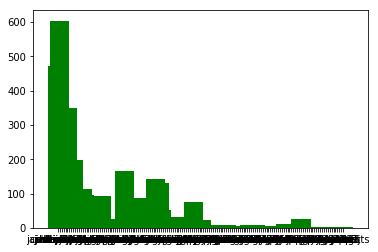

In [18]:
plt.bar(dev_counts.keys(), dev_counts.values(), width=10, color='g')
plt.show()

{'Hixie': 473, 'abarth': 604, 'collinjackson': 68, 'jason-simmons': 232, 'jimbeveridge': 2, 'HansMuller': 349, 'josephburnett': 1, 'eseidelGoogle': 49, 'devoncarew': 197, 'jamesr': 1, 'chinmaygarde': 105, 'leafpetersen': 2, 'TheBosZ': 1, 'sethladd': 114, 'yjbanov': 97, 'krisgiesing': 11, 'a14n': 6, 'mpcomplete': 67, 'johnmccutchan': 53, 'pylaligand': 4, 'aam': 36, 'qchong': 31, 'apwilson': 8, 'tvolkert': 94, 'alhaad': 4, 'stevemessick': 4, 'pq': 25, 'eseidel': 1, 'ianloic': 3, 'ppiet': 1, 'vlidholt': 2, 'Zectbumo': 1, 'MitchRudominer': 1, 'kaiyuanw': 1, 'aghassemi': 3, 'cbracken': 166, 'rmacnak-google': 25, 'dragostis': 23, 'danrubel': 45, 'dvdwasibi': 3, 'eukreign': 1, 'InMatrix': 2, 'mit-mit': 88, 'warent': 4, 'kwalrath': 3, 'raju-bitter': 2, 'LarkAscending': 14, 'beckler': 1, 'lukechurch': 2, 'lequem': 1, 'lukef': 5, 'goderbauer': 143, 'afandria': 1, 'xster': 132, 'jakobr-google': 53, 'Sfshaza': 7, 'weisong0': 1, 'hsbt': 1, 'mehmetf': 10, 'nex3': 1, 'ilikerobots': 1, 'vardhan-cr': 1

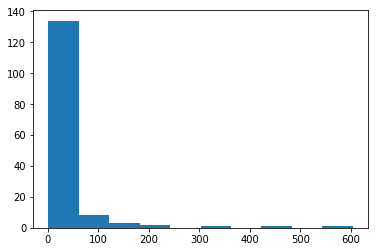

In [22]:
print(dev_counts)
print(len(dev_counts))
plt.hist(dev_counts.values())
plt.show()